In [10]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import contextily as cx
import momepy
import networkx as nx
import shapely
from cityseer.tools import io, graphs, plot
from cityseer.metrics import networks, layers
from matplotlib_scalebar.scalebar import ScaleBar

In [11]:
nodes = gpd.read_file('./wegengraaf2/points.shp').to_crs(epsg=3857)
lines = gpd.read_file('./wegengraaf2/lines.shp').to_crs(epsg=3857)
cities = gpd.read_file('./wegengraaf2/cities.shp').to_crs(epsg=3857)

## Modificaties shapefile data

In [12]:
lines_28992 = lines.to_crs(epsg=28992) # on average 1m accuracy, testing roughly gives the same result (1.92 km approx 2.00 km)
lines['length'] = lines_28992.length

In [13]:
lines['nbanen'] = 1 # rest, Nweg is 'Nxxx'
cond = lines['wegnr'].apply(lambda x: x is not None and x[0] == '0')
lines.loc[cond, 'nbanen'] = 2

In [14]:
# if x, y is nan, use geometry data
nodes.loc[np.isnan(nodes['x']), 'x'] = nodes[np.isnan(nodes['x'])].geometry.x
nodes.loc[np.isnan(nodes['y']), 'y'] = nodes[np.isnan(nodes['y'])].geometry.x

In [15]:
# negeer dit als QGIS open is
nodes.to_file('./wegengraaf2/points.shp')
lines.to_file('./wegengraaf2/lines.shp')

INFO:pyogrio._io:Created 277 records


INFO:pyogrio._io:Created 338 records


## Structuur shapefiles

In [16]:
nodes[nodes['is_auto_br'] == 1] # geeft alle steden weer

,x,y,nodeID,stad_naam,is_auto_br,spawn_hoev,geometry
245,645309.193407,645309.193407,1000.0,Leeuwarden,1.0,0.0,POINT (645291.136 7019484.41)
246,678687.356347,678687.356347,1001.0,Drachten,1.0,0.0,POINT (678687.356 7003402.433)
247,630507.335802,630507.335802,1002.0,Sneek,1.0,0.0,POINT (630507.336 6989434.974)
252,659133.629811,659133.629811,1003.0,Heerenveen,1.0,0.0,POINT (659133.63 6975404.715)
253,603962.072195,603962.072195,1004.0,Harlingen,1.0,0.0,POINT (603962.072 7015736.489)
254,645899.001627,645899.001627,1005.0,Joure,1.0,0.0,POINT (645899.002 6976587.413)
255,668019.682772,668019.682772,1006.0,Wolvega,1.0,0.0,POINT (668019.683 6960374.304)
256,617080.349435,617080.349435,1007.0,Franeker,1.0,0.0,POINT (617080.349 7017852.729)
257,667774.750484,667774.750484,1008.0,Dokkum,1.0,0.0,POINT (667774.75 7043345.249)
258,635511.580819,635511.580819,1009.0,Lemmer,1.0,0.0,POINT (635511.581 6954311.894)


In [17]:
lines

,wegnr,length,maxshd,node_start,node_end,nbanen,geometry
0,N393,1924.333925,80,0,1,1,"LINESTRING (634450.288 7034871.712, 634130.3 7..."
1,N393,1660.777370,50,0,86,1,"LINESTRING (636926.484 7034136.391, 635716.5 7..."
2,N380,2271.218173,60,2,3,1,"LINESTRING (678454.257 6976977.584, 678365.673..."
3,N380,1177.078109,60,2,216,1,"LINESTRING (678454.257 6976977.584, 678483.198..."
4,N353,4651.621140,30,2,12,1,"LINESTRING (682722.705 6970661.324, 682721.7 6..."
...,...,...,...,...,...,...,...
333,None,970.667816,50,700,705,1,"LINESTRING (644224.607 7020824.375, 644280.894..."
334,None,452.205056,50,601,610,1,"LINESTRING (643655.147 7022281.238, 643793.075..."
335,None,1694.272342,50,610,602,1,"LINESTRING (644369.127 7022525.655, 644961.406..."
336,None,847.520019,50,606,702,1,"LINESTRING (646675.363 7017890.871, 646509.038..."


In [18]:
import matplotlib.patheffects as pe

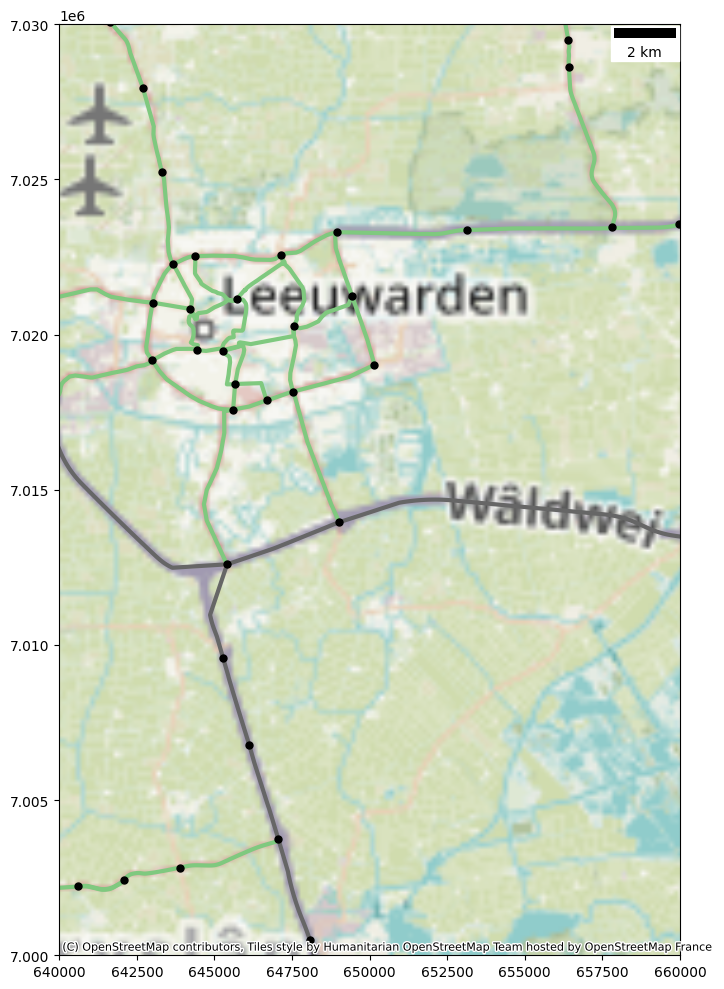

In [23]:
ax = lines.plot(column='nbanen',
                cmap='Accent',
                figsize=(15,10),
                linewidth=3,
                # legend=True,
                # legend_kwds={'label': 'Aantal banen', 'shrink': 0.6},
                zorder=1)

ax.add_artist(ScaleBar(1)) # scale bar (25 km)

nodes.plot(ax=ax, markersize=25, color='black', zorder=2)


# cities.plot(ax=ax, 
#             column='population',
#             cmap='viridis',
#             legend=True,
#             legend_kwds={'label': 'Population', 'shrink': 0.9},
#             zorder=3)

cx.add_basemap(ax)

ax.set_xlim((640_000, 660_000))
ax.set_ylim((7.00e6, 7.03e6))

# namen van steden
# cities.apply(lambda x: ax.annotate(text=x['name'], xy=x.geometry.centroid.coords[0], size=20, ha='center', color='white', path_effects=[pe.withStroke(linewidth=4, foreground="black")]), axis=1)

# cx.add_basemap(ax)

# ax.set_axis_off()

plt.tight_layout()

# plt.savefig('./friesland_finalnetwork.png', dpi=300)
